# Lotka Volterra

This is a demonstration of a predator-prey agent-based model.

We start with importing some libraries.

In [1]:
using Catlab, DataMigrations, AlgebraicRewriting
using Random, Test
using Luxor # optional: makes the sequence of images via `view_traj` at the end

using Catlab.Graphics.Graphviz: Attributes, Statement, Node
using Catlab.Graphics.Graphviz

const hom = homomorphism

Random.seed!(123);

# Ontology

Defining an ontology is stating what data is required to specify a state of the
simulation at some point in time. In AlgebraicJulia, this is done via declaring
a `Presentation`, i.e. a database schema. Objects (`Ob`, or tables) are types of
entities. Homs (`Hom`, or foreign keys) are functional relationships between the
aforementioned entities. AttrTypes are placeholders for Julia types, which are
assigned to `Ob` via attributes (`Attr`).

The schema below extends the schema for directed graphs, which consists in two
tables (`E` and `V`, for edges and vertices) and two homs (`src` and `tgt`,
`E→V`). It says there are two more types of entities, `Sheep` and `Wolf`, and
they can be thought of as living *on* the graph due to homs `sheep_loc` and
`wolf_loc` which assign each of them a vertex.

Furthermore, we want to give these entities some attributes. In this model,
wolves and sheep both have "energy", given by `Eng` (a type variable, which
we'll later instantiate with `Int`). Also, grass lives on vertices, and it's
represented by an integer. `countdown` being zero means the grass is ready to eat,
whereas a value above zero represents a counter of time the grass needs until it
grows back.

There is also a direction attribute type, and the edges (as well as animals) will
be oriented in a particular direction at any point in time.

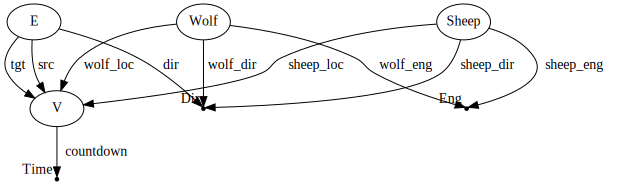

In [2]:
@present SchLV <: SchGraph begin
  (Sheep, Wolf)::Ob
  sheep_loc::Hom(Sheep, V); wolf_loc::Hom(Wolf, V)

  (Time, Eng)::AttrType
  countdown::Attr(V, Time);
  sheep_eng::Attr(Sheep, Eng); wolf_eng::Attr(Wolf, Eng)

  Dir::AttrType
  dir::Attr(E, Dir); sheep_dir::Attr(Sheep, Dir); wolf_dir::Attr(Wolf, Dir)
end

# efficient ABM rewriting uses BitSetParts rather than DenseParts to allow
# in-place pushout rewriting, rather than pure/non-mutating pushouts.)
@acset_type LV_Generic(SchLV, part_type=BitSetParts) <: HasGraph
const LV = LV_Generic{Int, Int, Symbol}

to_graphviz(SchLV; prog="dot")

We can further extend this schema with an additional attribute of (x,y)
coordinates for every vertex. This is nice for visualization but is otherwise
unnecessary when doing the actual agent-based modeling. So what we will do is
*build* our model with the LV schema and then *run* our model with the LV′ schema.

In [3]:
@present SchLV′ <: SchLV begin
  Coord::AttrType
  coord::Attr(V, Coord)
end

@acset_type LV′_Generic(SchLV′, part_type=BitSetParts) <: HasGraph
const LV′ = LV′_Generic{Int, Int, Symbol, Tuple{Int,Int}};

We will be representing directions as `Symbol`s and encode the geometry via
`left` and `right` functions. The attribute will only take values :N, :E, :W,
or :S.

In [4]:
import Catlab.CategoricalAlgebra: left, right

function right(s::Symbol)
  if s == :N
    return :E
  elseif s == :S
    return :W
  elseif s == :E
    return :S
  elseif s == :W
    return :N
  end
end

function left(s::Symbol)
  if s == :N
    return :W
  elseif s == :S
    return :E
  elseif s == :E
    return :N
  elseif s == :W
    return :S
  end
end;

# Data migration functors

The schema LV has a certain symmetry between wolves and sheep, and this
symmetry can be used to take *instances* of the schema (i.e. world states) and
swap the wolves and the sheep. This is helpful for avoiding repeating work:
there are certain actions that wolves and sheep share, so, by using this data
migration, we can define them in terms of sheep and then migrate along `F` to
obtain the analogous actions for wolves.

In [5]:
F = Migrate(
  Dict(:Sheep => :Wolf, :Wolf => :Sheep),
  Dict([:sheep_loc => :wolf_loc, :wolf_loc => :sheep_loc,
    :sheep_eng => :wolf_eng, :wolf_eng => :sheep_eng, :countdown => :countdown,
    :sheep_dir => :wolf_dir, :wolf_dir => :sheep_dir,]), SchLV, LV);

We ought to be able to take a state of the world (with no coordinate information)
and obtain a state of the world with coordinates (the canonical way to do this
is to assign "variables" for the values of the coordinates).

In [6]:
F2 = Migrate(SchLV, LV, SchLV′, LV′; delta=false);

# Initializing and visualizing world states

To help us create initial states for simulations, here is a helper function
that makes an n × n grid with periodic boundary conditions. Edges in each cardinal
direction originate at every point.

In [7]:
function create_grid(n::Int)
  lv = LV′()
  coords = Dict()
  for i in 0:n-1  # Initialize grass 50% green, 50% uniformly between 0-30
    for j in 0:n-1
      coords[i=>j] = add_part!(lv, :V; countdown=max(0, rand(-30:30)), coord=(i, j))
    end
  end
  for i in 0:n-1
    for j in 0:n-1
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[mod(i + 1, n)=>j], dir=:E)
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[mod(i - 1, n)=>j], dir=:W)
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[i=>mod(j + 1, n)], dir=:N)
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[i=>mod(j - 1, n)], dir=:S)
    end
  end
  lv
end;

To initialize a state of the world with sheep and wolves, we also accept
parameters which indicate the fraction of spaces that are
populated with that animal.

In [8]:
function initialize(n::Int, sheep::Float64, wolves::Float64)::LV′
  grid = create_grid(n)
  args = [(sheep, :Sheep, :sheep_loc, :sheep_eng, :sheep_dir),
    (wolves, :Wolf, :wolf_loc, :wolf_eng, :wolf_dir)]
  for (n_, name, loc, eng, d) in args
    for _ in 1:round(Int, n_ * n^2)
      dic = Dict([eng => 5, loc => rand(vertices(grid)),
        d => rand([:N, :E, :S, :W])])
      add_part!(grid, name; dic...)
    end
  end
  grid
end;

Some visualization code below will allow us to see states of the world. Edges
are left implicit (we know from how the graphs were constructed that there are
edges between every pair of adjacent vertices).

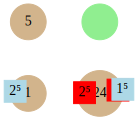

In [9]:
supscript_d = Dict(['1' => '¹', '2' => '²', '3' => '³', '4' => '⁴', '5' => '⁵', '6' => '⁶', '7' => '⁷', '8' => '⁸', '9' => '⁹', '0' => '⁰', 'x' => 'ˣ', 'y' => 'ʸ', 'z' => 'ᶻ', 'a' => 'ᵃ', 'b' => 'ᵇ', 'c' => 'ᶜ', 'd' => 'ᵈ'])
supscript(x::String) = join([get(supscript_d, c, c) for c in x]); # energy shown in superscript

function view_LV(p::ACSetTransformation, pth=tempname(); name="G", title="")
  if nparts(dom(p), :Wolf) == 1
    star = :Wolf => p[:Wolf](1)
  elseif nparts(dom(p), :Sheep) == 1
    star = :Sheep => p[:Sheep](1)
  elseif nparts(dom(p), :V) == 1
    star = :V => p[:V](1)
  else
    star = nothing
  end
  view_LV(codom(p), pth; name=name, title=title, star=star)
end

function view_LV(p::LV′, pth=tempname(); name="G", title="", star=nothing)
  pstr = ["$(i),$(j)!" for (i, j) in p[:coord]]
  stmts = Statement[]
  for s in 1:nv(p)
    st = (star == (:V => s)) ? "*" : ""
    gv = p[s, :countdown]
    col = gv == 0 ? "lightgreen" : "tan"
    push!(stmts, Node("v$s", Attributes(
      :label => gv == 0 ? "" : string(gv) * st,
      :shape => "circle",
      :color => col, :pos => pstr[s])))
  end
  d = Dict([:E => (1, 0), :N => (0, 1), :S => (0, -1), :W => (-1, 0),])

  args = [(:true, :Wolf, :wolf_loc, :wolf_eng, :wolf_dir),
    (false, :Sheep, :sheep_loc, :sheep_eng, :sheep_dir)]

  for (is_wolf, prt, loc, eng, dr) in args
    for w in parts(p, prt)
      st = (star == ((is_wolf ? :Wolf : :Sheep) => w)) ? "*" : ""
      e = only(incident(p, p[w, loc], :src) ∩ incident(p, p[w, dr], :dir))
      s = src(p, e)
      dx, dy = d[p[e, :dir]]
      (sx, sy) = p[s, :coord]

      L, R = 0.25, 0.1
      wx = sx + L * dx + R * rand()
      wy = sy + L * dy + R * rand()
      ID = "$(is_wolf ? :w : :s)$w"
      append!(stmts, [Node(ID, Attributes(
        :label => "$w" * supscript("$(p[w,eng])") * st,
        :shape => "square", :width => "0.3px", :height => "0.3px", :fixedsize => "true",
        :pos => "$(wx),$(wy)!", :color => is_wolf ? "red" : "lightblue"))])
    end
  end

  g = Graphviz.Digraph(name, Statement[stmts...]; prog="neato",
    graph_attrs=Attributes(:label => title, :labelloc => "t"),
    node_attrs=Attributes(:shape => "plain", :style => "filled"))
  open(pth, "w") do io
    show(io, "image/svg+xml", g)
  end
  g
end

init = initialize(2, 0.5, 0.5)
view_LV(init)

Not only can we visualize states of the world, but we can visualize certain
states of the world with certain distinguished agents, such as a sheep, wolf,
or patch of grass. The way we specify a state of the world (`X`) with a distinguished
sheep (for example) is a morphism `S → X`, where `S` is an ACSet with a single
sheep in it.

Below we manually construct a generic sheep (in LV, which doesn't have
coordinates). We then use the data migration to give it generic coordinates to
obtain a generic LV′ sheep. We use this as the domain of a hom that
assigns the sheep to Sheep #2 of the world state `init` from above.

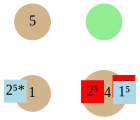

In [10]:
S = @acset LV begin V=1; Sheep=1; Dir=1; Eng=1; Time=1;
  sheep_loc=1; sheep_dir=[AttrVar(1)]; sheep_eng=[AttrVar(1)]; countdown=[AttrVar(1)]
end

view_LV(hom(F2(S), init; initial=(Sheep=[2],)))

It will be helpful to not have to manually construct "generic" world states
like above because it's tedious. We want to say "give me a sheep" or "give me a
sheep and a wolf that are on the same vertex" and have it automatically specify
the remaining information in the most generic way possible. The `@acset_colim`
macro is perfect for exactly this. In order to use
that macro, we need to compute something first with the `yoneda_cache` function.

In [11]:
yLV = yoneda_cache(LV; clear=false); # cache=false means reuse cached results
I = LV() # Empty agent type
S = @acset_colim yLV begin s::Sheep end # Generic sheep agent
W = F(S) # Generic wolf agent, obtained via the swapping `F` data migration
G = @acset_colim yLV begin v::V end # Generic grass agent
N = Names(Dict("W" => W, "S" => S, "G" => G, "" => I)); # give these ACSets names

# Rules

We have finished specifying what makes up a simulation state, and next is to
define what sorts of transitions are possible. This is done by declaring
rewrite rules. We also will put these rules into little boxes with an incoming
wire and two outgoing wires (called a `RuleApp`), where wires
correspond to the successful (resp. unsuccessful) application of the rewrite
rule. In the next section we will focus on assembling these miniature wiring
diagrams into an overall simulation.

Here we just note that the wires of the simulation must be labeled with an
*agent*. This is because, at all points in time, there is a
distinguished agent (i.e. a morphism `A → X`, where `A` is an ACSet with a
generic *something* in it, e.g. a generic sheep like above). So when we wrap
our rules into the `RuleApp` boxes, we need to also specify what those
distinguished agents are and how they relate to the pattern + replacement of
the rewrite rule within the box.

### Rotating

Our first action that is possible for sheep (and wolves) is rotation. Animals
will, with some probability, change their orientation. This is a rewrite rule
which only modifies an attribute rather than changing any combinatorial data,
so rather than the usual span `L ← I → R` data required we simply put in a
single ACSet along with an `expr` dictionary which states how attributes
change.

In [12]:
rl = Rule(S; expr=(Dir=[xs -> left(only(xs))],));
rr = Rule(S; expr=(Dir=[xs -> right(only(xs))],));

sheep_rotate_l = tryrule(RuleApp(:turn_left, rl, S));
sheep_rotate_r = tryrule(RuleApp(:turn_right, rr, S));

We can imagine executing these rules in sequence

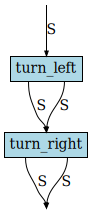

In [13]:
seq_sched = (sheep_rotate_l ⋅ sheep_rotate_r);
view_sched(seq_sched; names=N)

... or in parallel.

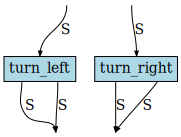

In [14]:
par_sched = (sheep_rotate_l ⊗ sheep_rotate_r);
view_sched(par_sched; names=N)

#### Test rotation

In [15]:
begin
  ex = @acset LV begin
    E=1; Sheep=1; V=2
    src=1; tgt=2; dir=:W; countdown = [0, 0]
    sheep_loc=1; sheep_eng=100; sheep_dir=:N
  end;

  expected = copy(ex);
  expected[:sheep_dir] = :W
  @test is_isomorphic(rewrite(rl, ex), expected)
  rewrite!(rl, ex)
  @test is_isomorphic(ex, expected)
end;

### Moving forward

In [16]:
s_fwd_l = @acset_colim yLV begin
  e::E; s::Sheep;
  sheep_loc(s) == src(e);
  dir(e) == sheep_dir(s)
end

s_fwd_i = @acset_colim yLV begin e::E end

s_fwd_r = @acset_colim yLV begin
  e::E; s::Sheep; sheep_loc(s) == tgt(e); dir(e) == sheep_dir(s)
end;

s_n = @acset_colim yLV begin
  e::E; s::Sheep;
  sheep_loc(s) == src(e); dir(e) == sheep_dir(s)
  sheep_eng(s) == 0
end;

sheep_fwd_rule = Rule(
  hom(s_fwd_i, s_fwd_l; monic=true),
  hom(s_fwd_i, s_fwd_r; monic=true),
  ac=[AppCond(hom(s_fwd_l, s_n), false)],
  expr=(Eng=[vs -> only(vs) - 1],))
;

sheep_fwd = tryrule(RuleApp(:move_fwd, sheep_fwd_rule,
  hom(S, s_fwd_l), hom(S, s_fwd_r)));

#### Moving forward test

In [17]:
begin
  ex = @acset LV begin
    V=3; E=2; Sheep=1;
    countdown=[0,0,0]
    src=[1,2]; tgt=[2,3]; dir=[:N,:W]
    sheep_loc=1; sheep_dir=:N; sheep_eng = 10
  end
  expected = copy(ex);
  expected[:sheep_loc] = 2
  expected[:sheep_eng] = 9
  @test is_isomorphic(expected, rewrite(sheep_fwd_rule, ex))
  rewrite!(sheep_fwd_rule, ex)
  @test is_isomorphic(ex, expected)
end;

### Sheep eat grass

In [18]:
s_eat_pac = @acset_colim yLV begin s::Sheep; countdown(sheep_loc(s)) == 0 end;

se_rule = Rule(S; expr=(Eng=[vs -> only(vs) + 4], Time=[vs -> 30],),
  ac=[AppCond(hom(S, s_eat_pac))]);

sheep_eat = tryrule(RuleApp(:Sheep_eat, se_rule, S));

#### Sheep eating test

In [19]:
begin
  ex = @acset LV begin
    E=1; V=2; Sheep=1;
    src=1; tgt=2; dir=:S; countdown=[10, 0]
    sheep_loc = 2; sheep_eng = 3; sheep_dir=:W
  end

  expected = copy(ex)
  expected[2,:countdown] = 30
  expected[1,:sheep_eng] = 7

  @test is_isomorphic(expected, rewrite(se_rule, ex))
  rewrite!(se_rule, ex)
  @test is_isomorphic(ex, expected)
end;

### Wolves eat sheep

In [20]:
w_eat_l = @acset_colim yLV begin
  s::Sheep; w::Wolf
  sheep_loc(s) == wolf_loc(w)
end;

we_rule = Rule(hom(W, w_eat_l), id(W); expr=(Eng=[vs -> vs[2] + 20],));

wolf_eat = tryrule(RuleApp(:Wolf_eat, we_rule, W));

#### Wolf eating test

In [21]:
begin
  ex = @acset LV begin
    Sheep=1; Wolf=1; V=3; E=2;
    src=[1,2]; tgt=[2,3]; countdown=[9,10,11]; dir=[:N,:N];
    sheep_loc=2; sheep_eng=[3]; sheep_dir=[:N]
    wolf_loc=[2];  wolf_eng=[16];  wolf_dir=[:S]
  end

  expected = copy(ex)
  expected[1, :wolf_eng] = 36
  rem_part!(expected, :Sheep, 1)

  @test is_isomorphic(rewrite(we_rule,ex), expected)
  rewrite!(we_rule, ex)
  @test is_isomorphic(ex,expected)
end;

### Sheep starvation

In [22]:
s_die_l = @acset_colim yLV begin s::Sheep; sheep_eng(s) == 0 end;

sheep_die_rule = Rule(hom(G, s_die_l), id(G))
sheep_starve = (RuleApp(:starve, sheep_die_rule,
  hom(S, s_die_l), create(G))
                ⋅
                (id([I]) ⊗ Weaken(create(S))) ⋅ merge_wires(I));

#### Sheep starvation test

In [23]:
begin
  ex = @acset LV begin
    V=1; Sheep=1; Wolf=1
    countdown=20;
    sheep_loc=1; sheep_eng=0; sheep_dir=:W
    wolf_loc=1; wolf_eng=10; wolf_dir=:S
  end
  expected = copy(ex)
  rem_part!(expected, :Sheep, 1)

  @test is_isomorphic(rewrite(sheep_die_rule,ex), expected)
  rewrite!(sheep_die_rule,ex)
  @test is_isomorphic(ex, expected)
end;

### Reproduction

In [24]:
s_reprod_r = @acset_colim yLV begin
  (x, y)::Sheep
  sheep_loc(x) == sheep_loc(y)
end;

sheep_reprod_rule = Rule(
  hom(G, S),
  hom(G, s_reprod_r);
  expr=(Dir=fill(vs->only(vs) ,2),
        Eng=fill(vs -> round(Int, vs[1] / 2, RoundUp), 2),)
);

sheep_reprod = RuleApp(:reproduce, sheep_reprod_rule,
  id(S), hom(S, s_reprod_r; any=true)) |> tryrule;

#### Reproduction test

In [25]:
begin # test
  ex = @acset LV begin
    Sheep=1; Wolf=1; V=2;
    countdown=[20,30]
    sheep_loc=1; sheep_eng=10; sheep_dir=:W
    wolf_loc=2; wolf_eng=5; wolf_dir=:N
  end

  expected = copy(ex)
  add_part!(expected,:Sheep)
  expected[:sheep_eng] = [5, 5]
  expected[:sheep_loc] = [1, 1]
  expected[:sheep_dir] = [:W, :W]

  @test is_isomorphic(rewrite(sheep_reprod_rule,ex),expected)
  rewrite!(sheep_reprod_rule,ex)
  @test is_isomorphic(ex, expected)
end;

### Grass increments

In [26]:
g_inc_n = deepcopy(G)
set_subpart!(g_inc_n, 1, :countdown, 0)
rem_part!(g_inc_n, :Time, 1);

g_inc_rule = Rule(id(G), id(G);
  ac=[AppCond(hom(G, g_inc_n), false)],
  expr=(Time=[vs -> only(vs) - 1],));

g_inc = RuleApp(:GrassIncrements, g_inc_rule, G) |> tryrule;

#### Grass incrementing test

In [27]:
begin
  ex = @acset LV begin
    Sheep = 1; V = 3; E = 2
    src = [1, 2]; tgt = [2, 3]
    sheep_loc = 2; sheep_eng = [3]; sheep_dir = [:N]
    countdown = [1, 10, 2]; dir = fill(:N, 2)
  end
  expected = @acset LV begin
    Sheep = 1; V = 3; E = 2
    src = [1, 2]; tgt = [2, 3]
    sheep_loc = 2; sheep_eng = [3]; sheep_dir = [:N]
    countdown = [0, 10, 2]; dir = fill(:N, 2)
  end
  m = get_matches(g_inc_rule, ex)[1]
  @test is_isomorphic(rewrite_match(g_inc_rule, m), expected)
  rewrite_match!(g_inc_rule, m)
  @test is_isomorphic(ex, expected)
end;

## Assembling rules into a recipe

Now we can assemble our building block transitions into a large wiring diagram
characterizing the flow of the overall ABM simulation. In addition
to the blue rewrite rule blocks, we have red (probabilistic) control flow blocks
and yellow `Query` blocks.

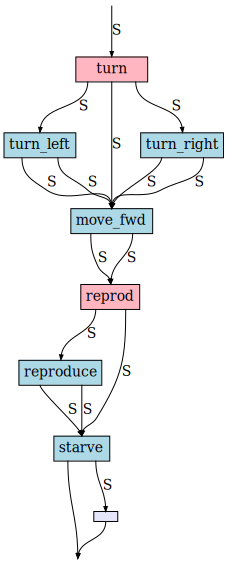

In [28]:
general = mk_sched((;), (init=:S,), N, (
    turn=const_cond([1.0, 2.0, 1.0], S; name=:turn),
    maybe=const_cond([0.1, 0.9], S; name=:reprod),
    lft=sheep_rotate_l,
    rght=sheep_rotate_r,
    fwd=sheep_fwd,
    repro=sheep_reprod,
    starve=sheep_starve),
  quote
    out_l, out_str, out_r = turn(init)
    moved = fwd([lft(out_l), out_str, rght(out_r)])
    out_repro, out_no_repro = maybe(moved)
    return starve([repro(out_repro), out_no_repro])
  end);

view_sched(general; names=N)

The above was content common to wolves and sheep. The difference is how they
eat.

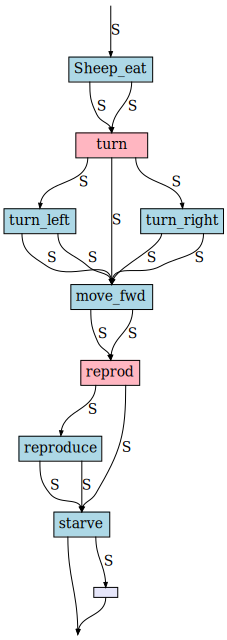

In [29]:
sheep = sheep_eat ⋅ general;   # executed once per sheep

view_sched(sheep; names=N)

We use the swap data migration functor `F` to translate the sheep routine
into a wolf one so that it can be composed with the wolf eating step.

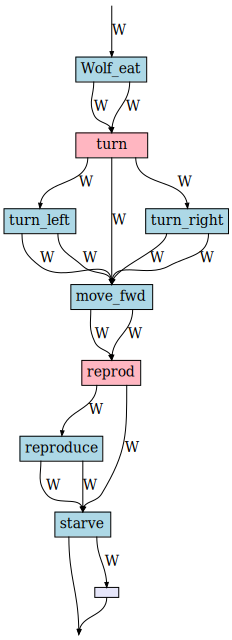

In [30]:
wolf = wolf_eat ⋅ F(general);  # executed once per wolf

view_sched(wolf; names=N)

Do all sheep, then all wolves, then all daily operations

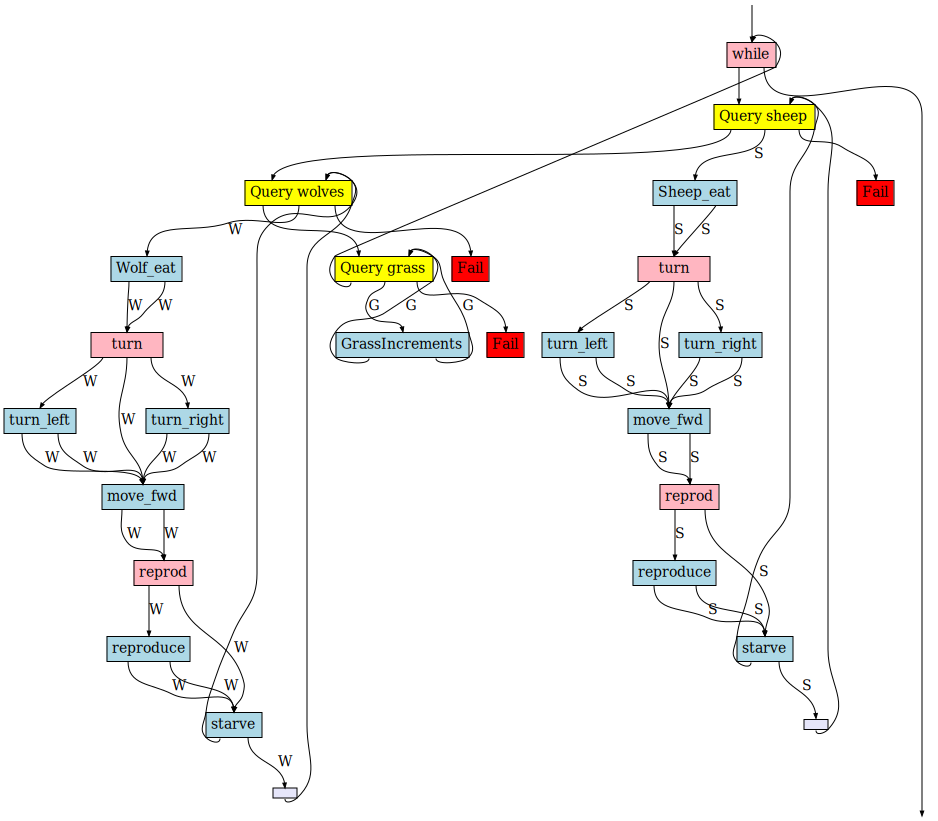

In [31]:
cycle = (agent(sheep; n=:sheep, ret=I)
         ⋅
         agent(wolf; n=:wolves, ret=I)
         ⋅
         agent(g_inc; n=:grass))

view_sched(cycle; names=N)

#=
Wrap the whole thing in a while loop. Also apply the F2 migration to give
everything coordinates.
=#

overall = while_schedule(cycle, curr -> nparts(curr, :Wolf) >= 0) |> F2

view_sched(overall; names=F2(N))

## Running the simulation

In [32]:
X = initialize(3, 0.25, 0.25); # 3 × 3 grid, 2 sheep + wolves

Encourage something exciting to happen by placing a wolf on top of a sheep

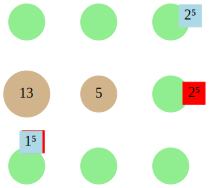

In [33]:
X[1, :wolf_loc] = X[1, :sheep_loc]
X[1, :wolf_dir] = X[1, :sheep_dir]

view_LV(X)

Run the simulation for 100 steps

In [34]:
res = interpret(overall, X; maxstep=100);

┌ Warning: Exceeded maximum number of steps
└ @ AlgebraicRewriting.Schedules.Eval ~/work/AlgebraicRewriting.jl/AlgebraicRewriting.jl/src/schedules/Eval.jl:72


## Visualizing the results

Run this line to view the trajectory in the generated `traj` folder

In [35]:
view_traj(overall, res[1:10], view_LV; agent=true, names=F2(N));